<a href="https://www.kaggle.com/alperenkaran/titanic-with-clear-explanations?scriptVersionId=88893526" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Libraries

In [1]:
import numpy as np; np.set_printoptions(suppress=True) # suppress scientific notation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm #create progress bars

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# learning algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# cross validation
from sklearn.model_selection import GridSearchCV

## Section 1: First look at the data

We load the train.csv and test.csv files

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

Let's look at sample 3 rows from `train` and `test`:

In [3]:
train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
603,604,0,3,"Torber, Mr. Ernst William",male,44.0,0,0,364511,8.0500,NaN,S
807,808,0,3,"Pettersson, Miss. Ellen Natalia",female,18.0,0,0,347087,7.7750,NaN,S
411,412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q


In [4]:
test.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
218,1110,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.500,C80,C
210,1102,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.525,NaN,S
124,1016,3,"Kennedy, Mr. John",male,NaN,0,0,368783,7.750,NaN,Q


The `train` data contains an extra column `Survived` which constitute the labels for supervised learning.

Below we write that column to a variable `y_train`, and other columns of `train` to a variable called `x_train`. For consistency, we rename `test` as `x_test`. Our ultimate goal is to find `y_test`, that is, the labels corresponding to `x_test`.

In [5]:
y_train = train['Survived']
x_train = train.drop('Survived', 1)
x_test = test

## Section 2: Handling missing data

Let's now look at the frequency and percentage of missing values in `train` and `test`.

In [6]:
train_missing_count = x_train.isnull().sum()
train_missing_percent = (x_train.isnull().mean()*100).round(2)
test_missing_count = x_test.isnull().sum()
test_missing_percent = (x_test.isnull().mean()*100).round(2)

missing_info = pd.concat([train_missing_count, train_missing_percent, test_missing_count, test_missing_percent], axis = 1)
missing_info.columns = ['train missing counts', 'train missing percentage', 'test missing count', 'test missing percentage']
missing_info.sort_values('train missing counts', ascending = False)

,train missing counts,train missing percentage,test missing count,test missing percentage
Cabin,687,77.10,327,78.23
Age,177,19.87,86,20.57
Embarked,2,0.22,0,0.00
PassengerId,0,0.00,0,0.00
Pclass,0,0.00,0,0.00
Name,0,0.00,0,0.00
Sex,0,0.00,0,0.00
SibSp,0,0.00,0,0.00
Parch,0,0.00,0,0.00
Ticket,0,0.00,0,0.00


There are missing data in `Cabin`, `Age`,`Embarked` and `Fare` columns. We will handle them separately below.

### 2.1 The `Cabin` feature

The `Cabin` information is missing in approximately 78% of the `x_train` and `x_test` sets. Let's look at the unique non-nan values in `x_train`.

In [7]:
x_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

As shown above, the `Cabin` column contains many unique values. So, it may be a good idea to remove this feature from further analyses. Below we delete this column from `x_train` and `x_test` data.

In [8]:
x_train = x_train.drop('Cabin', 1)
x_test = x_test.drop('Cabin', 1)

### 2.2 The `Embarked` feature

For this feature, there are only 2 missing values in the `x_train` data, and no missing values in `x_test`. Let's look at them:

In [9]:
x_train[x_train['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


To fill in the two missing `Embarked` values, let's look at the frequency table of this feature below.

In [10]:
embarked_freq = x_train['Embarked'].value_counts().rename('Embarked frequency')
embarked_percent = (x_train['Embarked'].value_counts(normalize = True)*100).round(2).rename('Embarked percent')
pd.concat([embarked_freq,embarked_percent], axis = 1)

,Embarked frequency,Embarked percent
S,644,72.44
C,168,18.90
Q,77,8.66


The table above shows that about 72% of the data have `Embarked` value of `S`. However, it is still possible that the frequencies change with respect to other features. For instance, it is possible that most females embarked from not `S` but `C`. 

Let's see whether the frequency of `Embarked` feature differs with respect to some other features:

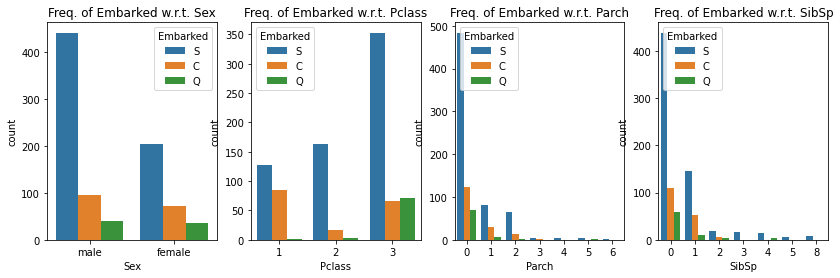

In [11]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i,colname in enumerate(['Sex','Pclass','Parch','SibSp']):
    sns.countplot(data=x_train, x=colname, hue='Embarked', ax=ax[i]).set_title('Freq. of Embarked w.r.t. ' + colname)
plt.show()

Clearly, most `females` in 1st `Pclass` with 0 `Parch` and 0 `SibSp` were `Embarked` from `S`. So, we will fill the missing values with `S` below.

In [12]:
x_train['Embarked'] = x_train['Embarked'].fillna('S')

### 2.3 The `Fare` feature

The only missing value for `Fare` exists in `x_test`. Let's have a look:

In [13]:
x_test[x_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


This person is a `male` in the 3rd `Pclass` with no `SibSp` or `Parch`. Since `Fare` is a continuous variable, we will replace the `NaN`value with group median.

**Caution 1:** The group (`males` in the 3rd `Pclass` with no `SibSp` or `Parch`) should be obtained from `x_train`, not `x_test` in order to prevent data leakage.

**Caution 2:** In order the median to be reliable, the group  should contain enough number of data.

In [14]:
fare_group = x_train[(x_train['Pclass']==3) & (x_train['Sex']=='male') & (x_train['SibSp']==0) & (x_train['Parch']==0)]

print('The median is', fare_group['Fare'].median())
print('The number of people in this group is', len(fare_group))

The median is 7.8958
The number of people in this group is 264


Since the group is large enough, we can safely replace the missing value with the median.

In [15]:
x_test['Fare'] = x_test['Fare'].fillna(fare_group['Fare'].median())

### 2.4 The `Age` feature

About 20% of the `Age` column is missing in both `x_train` and `x_test`.

Let's look at how `Age` behaves with respect to `Pclass` and `Sex`.

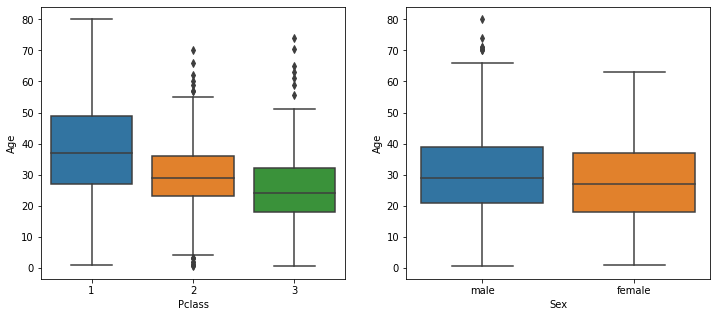

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(y='Age', x='Pclass', data=x_train, ax = ax[0])
sns.boxplot(y = 'Age', x = 'Sex', data = x_train, ax = ax[1])
plt.show()

The boxplots above show that passengers in `Pclass` 1 had a higher median age than passengers in `Pclass` 2 or 3. No similar pattern was observed for `Sex`. So, let's impute the missing `Age`s with `Pclass` median value.

In [17]:
x_train['Age'] = x_train['Age'].fillna(x_train.groupby('Pclass')['Age'].transform('median'))
x_test['Age'] = x_test['Age'].fillna(x_train.groupby('Pclass')['Age'].transform('median'))

### 2.5 Last check

Let's check our train and test sets for any remaining missing values.

In [18]:
print('x_train contains', x_train.isnull().sum().sum(), 'missing values.')
print('x_test contains', x_test.isnull().sum().sum(), 'missing values.')

x_train contains 0 missing values.
x_test contains 0 missing values.


So we are good to go!

## Section 3: Feature engineering

Now that we have imputed all missing data, let's take a look at the training data again.

In [19]:
x_train.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
265,266,2,"Reeves, Mr. David",male,36.0,0,0,C.A. 17248,10.5000,S
552,553,3,"O'Brien, Mr. Timothy",male,24.0,0,0,330979,7.8292,Q
290,291,1,"Barber, Miss. Ellen ""Nellie""",female,26.0,0,0,19877,78.8500,S
40,41,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,S
662,663,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,S


### 3.1 Have family at the ship?

Perhaps an obvious feature should be whether the person have some family at the ship or not. 

This is simply whether the sum of `SibSp` (siblings&spouse) and `Parch` (parents&children) is a positive number of not.

In [20]:
x_train['haveFamily'] = (x_train['SibSp'] + x_train['Parch'] > 0)*1 #multipy by 1 to convert True/False to 1/0
x_test['haveFamily'] = (x_test['SibSp'] + x_test['Parch'] > 0)*1

### 3.2 Title, please

In titanic, there were people with very different titles including _Mr, Mrs, Dr, Master, Lady_ and so on.

Let's first extract the titles from the names, then we will look at the frequency of each title.

In [21]:
x_train['Title'] = x_train['Name'].map(lambda x: x.split('.')[0].split(' ')[-1])
x_test['Title'] = x_test['Name'].map(lambda x: x.split('.')[0].split(' ')[-1])

In [22]:
print('The frequency of each title in x_train:')
pd.DataFrame(x_train['Title'].value_counts()).T

The frequency of each title in x_train:


,Mr,Miss,Mrs,Master,Dr,Rev,Col,Major,Mlle,Jonkheer,Sir,Don,Lady,Mme,Capt,Ms,Countess
Title,517,182,125,40,7,6,2,2,2,1,1,1,1,1,1,1,1


In [23]:
print('The frequency of each title in x_test:')
pd.DataFrame(x_test['Title'].value_counts()).T

The frequency of each title in x_test:


,Mr,Miss,Mrs,Master,Rev,Col,Ms,Dr,Dona
Title,240,78,72,21,2,2,1,1,1


We may further want to look at the effect of the title for survival.

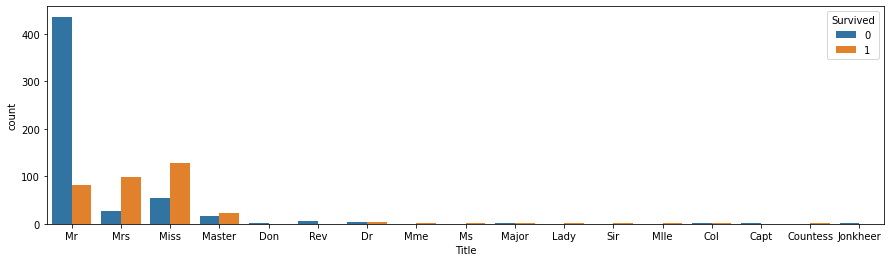

In [24]:
plt.figure(figsize=(15,4))
sns.countplot(data=x_train, x='Title', hue=y_train)
plt.show()

By looking at the above plot, we can say that if you were a _Mr_ in Titanic, chances are you had died in the ocean. On the other hand, being a _Mrs_ and _Miss_ does not appear to differ. Lastly, we can combine other titles in a title called _other_.

In [25]:
def newTitle(title):
    if title == 'Mr':
        return 'Mr'
    elif title in ['Mrs','Miss']:
        return 'Ms'
    else:
        return 'other'

In [26]:
x_train['Title'] = x_train['Title'].map(newTitle)
x_test['Title'] = x_test['Title'].map(newTitle)

### 3.3 Thoughts for other features

We can generate features such as:
- Do you have a large family? (more than 3 people)
- Do you have a royal title? (e.g. Sir, but not Dr)
- Convert the continuous `Fare` feature into ordinal: _cheap, medium_, and _expensive_.

But since we want this notebook to be introductory, we stop our feature engineering here.

## Section 4: Feature selection

Let's look at our data once more to drop the useless features.

In [27]:
x_train.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,haveFamily,Title
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,S,1,Ms
338,339,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,S,0,Mr
149,150,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,S,0,other
100,101,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,S,0,Ms
323,324,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1,1,248738,29.0000,S,1,Ms


The `PassengerId` and `Ticket` features are useless for our task. Also, we extracted information from `Name` to create the `Title`, and now `Name` also became useless. Let's delete these columns.

But note that we will need the `PassengerId` of `x_test` for our submission file. So, we store them in a variable before deleting it from `x_test`.

In [28]:
x_test_PassengerId = x_test['PassengerId']
x_train = x_train.drop(['PassengerId','Ticket','Name'], axis=1)
x_test = x_test.drop(['PassengerId','Ticket','Name'], axis=1)

We are not really sure whether `SibSp` or `Parch` will be important for the task, but let's keep them for now.

## Section 5: Handling categorical features

Most learning algorithms do not support categorical variables. So, we might want to convert them to numerical ones. 

The categorical variables for this task are `Sex`, `Embarked` and `Title`. Since `Sex` contains values from two categories (male&female) one numerical feature will be enough for it (1 for female, 0 for male). For the `Embarked` and `Title` columns, we will use one-hot-encoding with _get_dummies_ function from pandas.

In [29]:
x_train['Sex'] = (x_train['Sex'] == 'female')*1
x_test['Sex'] = (x_test['Sex'] == 'female')*1

In [30]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [31]:
x_train.sample(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,haveFamily,Embarked_C,Embarked_Q,Embarked_S,Title_Mr,Title_Ms,Title_other
340,2,0,2.0,1,1,26.0000,1,0,0,1,0,0,1
344,2,0,36.0,0,0,13.0000,0,0,0,1,1,0,0
324,3,0,24.0,8,2,69.5500,1,0,0,1,1,0,0
652,3,0,21.0,0,0,8.4333,0,0,0,1,1,0,0
400,3,0,39.0,0,0,7.9250,0,0,0,1,1,0,0


What a lovely data we ended up with.

## Section 6: Cross Validation

Now that we have successfully created the feature vectors, it is time to find a good learning algorithm. For this purpose, we will try a bunch of classification algorithms and make a grid search.

But before feeding the data into the learning algorithm, we will scale the features to the range [0,1] using MinMaxScaler.

In [32]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

### 6.1 Classifiers

We will try a bunch of classifiers for cross validation. We hold the classifiers in a list. I also created another list holding the names of these classifiers.

In [33]:
knn = KNeighborsClassifier()
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lda = LinearDiscriminantAnalysis()
lr = LogisticRegression()
ab = AdaBoostClassifier()

classifiers = [knn, svc, dt, rf, lda, lr, ab]
classifier_names = ['knn', 'svc', 'dt', 'rf', 'lda', 'lr', 'ab']

### 6.2 Parameters

Each classifer has its own hyperparameters. We hold the hyperparameters for each classifier in a dictionary, and put all of them into a list.

In [34]:
knn_params = {'n_neighbors':range(2,12), 'p':[1,2,3]}
svc_params = {'C':[.1,.2,.5,1,1.5,2], 'kernel':['rbf','linear','poly']}
dt_params = {'min_samples_split':[2,4,8,16,32,64]}
rf_params = {'min_samples_split':[2,4,8,16,32,64], 'n_estimators':[10,20,30,50], 'max_features':[2,4,6,8,10]}
lda_params = {'solver':['svd','lsqr']}
lr_params = {'C':[.2,.5,1,2,3]}
ab_params = {'n_estimators':[10,20,30,50], 'learning_rate':[.3,.5,1,1.5]}

parameters = [knn_params, svc_params, dt_params, rf_params, lda_params, lr_params, ab_params]

### 6.3 Grid search

Scikit-learn's `GridSearchCV` function finds the best parameters for a classifier in a parameter grid. Iterating over the classifier, we will find the best hyperparameters.

In [35]:
results = {}

for clf, clf_name, param in zip(tqdm(classifiers), classifier_names, parameters):
    search = GridSearchCV(clf, param)
    search.fit(x_train_scaled, y_train)
    results[clf_name] = [search.best_params_, search.best_score_]
    
results = pd.DataFrame(results).T
results.columns = ['Best Parameters', 'Score']

  0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
results

,Best Parameters,Score
knn,"{'n_neighbors': 8, 'p': 1}",0.813703
svc,"{'C': 1, 'kernel': 'poly'}",0.827155
dt,{'min_samples_split': 16},0.808104
rf,"{'max_features': 10, 'min_samples_split': 16, ...",0.838378
lda,{'solver': 'svd'},0.808079
lr,{'C': 2},0.810332
ab,"{'learning_rate': 1.5, 'n_estimators': 10}",0.815931


The results show that **Random Forest Classifier** is the best algorithm for our task reaching approximately **84%** accuracy. So, we will use its hyperparameters (found by the GridSearchCV) to make our predictions for submission.

## Section 7: Predicting `y_test`

The best hyperparameters were given in `results['Best Parameters']['rf']`. So, use them to create a classifier, and train it on `x_train_scaled`, and predict for `x_test_scaled`.

In [37]:
clf = RandomForestClassifier(**results['Best Parameters']['rf'])
clf.fit(x_train_scaled, y_train)
predictions = clf.predict(x_test_scaled)

In [38]:
submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
submission['PassengerId'] = x_test_PassengerId
submission['Survived'] = predictions

In [39]:
submission.to_csv('submission.csv',index = False)